In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.linalg import svd
from scipy.linalg import cholesky
import numpy as np
from scipy.linalg import svd, cholesky
from scipy.optimize import least_squares


%matplotlib inline

# Affine Structure from Motion (50 points)

## Overview
<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/sfm_hw.jpg" width="800"/>


This problem continues the interest point detection and tracking problem from HW2. Now, you will recover a 3D pointcloud from the image sequence hotel.seq0.png … hotel.seq50.png. You are encouraged to use your results from HW2, but in case you were not able to complete it, we have also included pre- computed intermediate results in the supplemental material. Submit your code so that we can reproduce your results.

The outline of the affine structure from motion algorithm:

<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/sfm_algo.jpg" width="700"/>


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part2_data/tracks.mat')

### Code

Helper Functions:

In [ ]:
# The following two functions are Helper Functions used in AssineSFM


def remove_nan(track_x, track_y):
  mask = np.logical_not(np.isnan(track_x) | np.isnan(track_y))
  mask = np.all(mask, axis=1)  # Keep only rows where all values are not nan
  track_x_no_nan = track_x[mask]
  track_y_no_nan = track_y[mask]
  return track_x_no_nan, track_y_no_nan


def orthonormality_residuals(L_vec, A):
    # Matrix L is symmetric, so it mirrors about its main diagonal
    # there are only 6 unique values: l1, l2, l3, l4, l5, l6.
    # These 6 values could be arranged acc. to matrix symmetry constraint:
    L = np.array([[L_vec[0], L_vec[1], L_vec[2]],
                  [L_vec[1], L_vec[3], L_vec[4]],
                  [L_vec[2], L_vec[4], L_vec[5]]])

    residuals = []
    for i in range(0, A.shape[0], 2):
        ai1 = A[i, :]
        ai2 = A[i + 1, :]
        # Define Orthonormality residuals matrix to calc the deviation of the
        # sol'n from the constraints
        residuals.extend([
            ai1.T @ L @ ai1 - 1,
            ai2.T @ L @ ai2 - 1,
            ai1.T @ L @ ai2

        ])
    return residuals


In [ ]:
def affineSFM(track_x, track_y):
  '''
  Function: Affine structure from motion algorithm
  % Normalize x, y to zero mean
  % Create measurement matrix
  D = [xn' ; yn'];
  % Decompose and enforce rank 3
  % Apply orthographic constraints
  '''
  m, n = track_x.shape

  # 1. Center the feature coordinate (subtract the corresponding centroid)
  centroids_x = np.nanmean(track_x, axis=0)
  centroids_y = np.nanmean(track_y, axis=0)

  track_x_centered = track_x - centroids_x
  track_y_centered = track_y - centroids_y

  # 2. Construct the centroid-subtracted measurement matrix D
  D = np.vstack((track_x_centered.T, track_y_centered.T))

  # 3. Factorize D using SVD and enforce rank constraint
  U, W, Vt = svd(D, full_matrices=False)
  U3 = U[:, :3]
  W3 = np.diag(W[:3])
  V3 = Vt[:3, :]

  # 4. Create the motion (affine) and structure (3D shape) matrices
  A = U3 @ np.sqrt(W3)
  S = np.sqrt(W3) @ V3

  #5. Solve L using the three orthonormality conditions (eliminate affine ambiguity)
  # Initialize the solution with an IC which is 1D for least_squares to work
  initial_guess = np.array([1, 0, 0, 1, 0, 1])
  L_opt = least_squares(orthonormality_residuals, initial_guess, args=(A,))
  # Handle solution from least_squares to construct the output 1D array back into a 3x3 sym matrix
  L = np.array([[L_opt.x[0], L_opt.x[1], L_opt.x[2]],
                [L_opt.x[1], L_opt.x[3], L_opt.x[4]],
                [L_opt.x[2], L_opt.x[4], L_opt.x[5]]])

  # Update A and S
  C = cholesky(L)
  A = A @ C
  S = np.linalg.inv(C) @ S

  return A, S


track_x = data['track_x']
track_y = data['track_y']

# Remove the nan value
track_x_no_nan, track_y_no_nan = remove_nan(track_x, track_y)

# Recover the 3D point cloud and Camera frame motion
A, S = affineSFM(track_x_no_nan, track_y_no_nan)


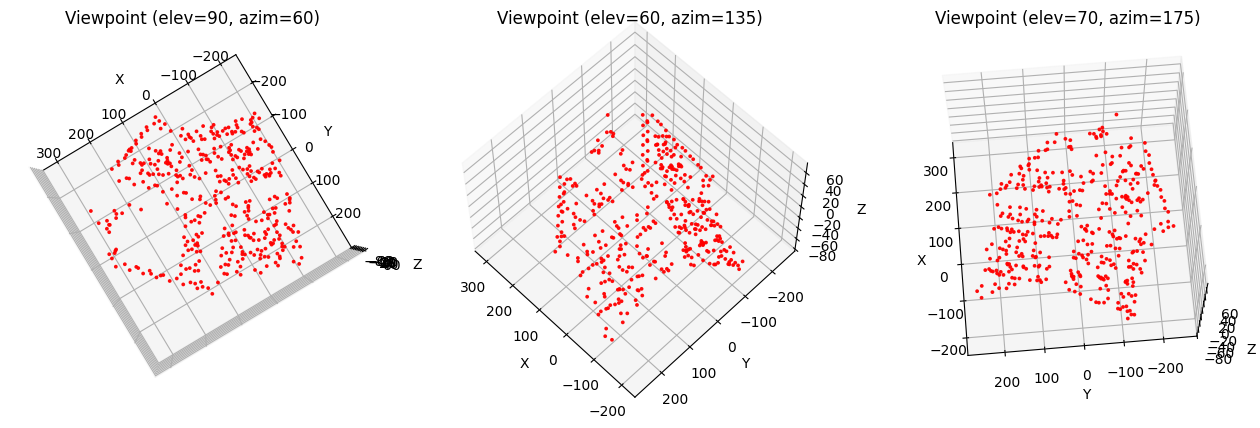

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_points(S, elevations, azimuths,roll, title_prefix):
    fig = plt.figure(figsize=(16, 5))

    for idx, (elev, azim, roll_angle) in enumerate(zip(elevations, azimuths,roll)):
        ax = fig.add_subplot(1, 3, idx + 1, projection='3d')
        ax.scatter(S[0, :], S[1, :], S[2, :], marker='o', s=3, c="red", alpha=0.9)
        ax.view_init(elev=elev, azim=azim, roll=roll_angle)
        ax.set_title(f"{title_prefix} (elev={elev}, azim={azim})")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

    plt.show()

# Change below angles for different view angles
elevations = [90, 60, 70]
azimuths = [60, 135, 175]
roll = [0, 0, 0]
plot_3D_points(S, elevations, azimuths,roll, 'Viewpoint')


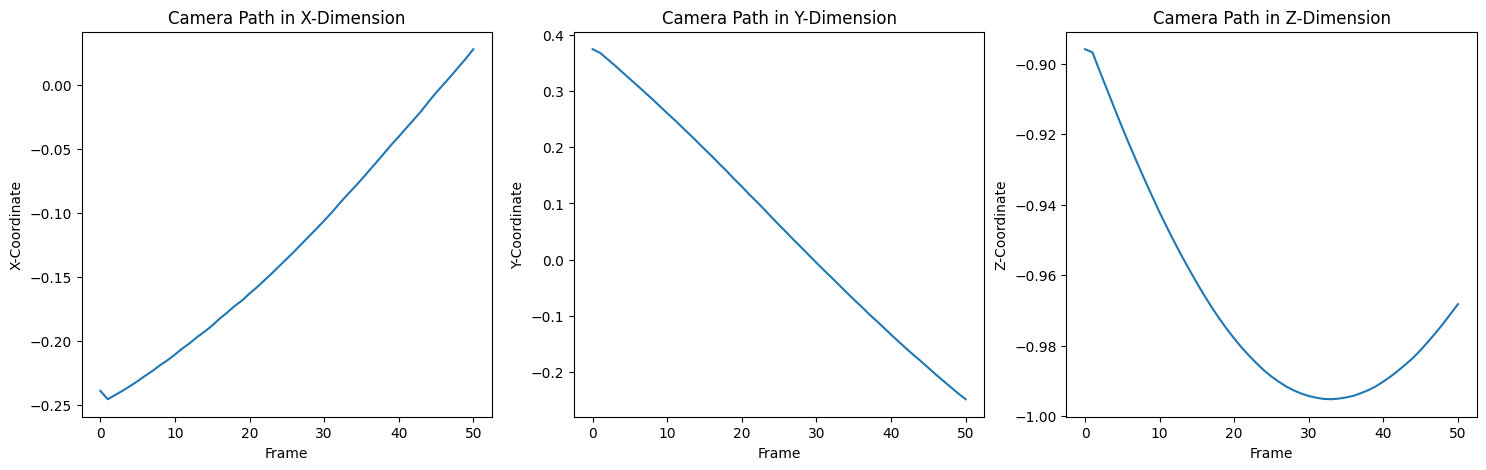

In [ ]:
def camera_positions(A):
    camera_pos = []
    for i in range(51):
        ai = A[i, :]
        aj = A[i + 51, :]
        ak = np.cross(ai, aj)
        ak_normalized = ak / np.linalg.norm(ak)
        camera_pos.append(ak_normalized)
        #camera_pos.append(ak)
    return np.array(camera_pos)

def plot_camera_path(camera_pos, dimension):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    dimensions = ['X', 'Y', 'Z']
    for idx, ax in enumerate(axes):
        ax.plot(camera_pos[:, idx], linestyle='-', markersize=6)
        ax.set_title(f'Camera Path in {dimensions[idx]}-Dimension')
        ax.set_xlabel('Frame')
        ax.set_ylabel(f'{dimensions[idx]}-Coordinate')

    plt.show()

# Plot predicted camera position
camera_pos = camera_positions(A)
plot_camera_path(camera_pos, ['X', 'Y', 'Z'])


### Write-up


*   Plot the predicted 3D locations of the tracked points for 3 different viewpoints. Choose the viewpoints so that the 3D structure is clearly visible. -> Results shown Above
*   Plot the predicted 3D path of the cameras. The camera position for each frame is given by the cross product a_k = a_i x a_j. Normalize a_k to be unit length for consistent results. Give 3 plots, one for each dimension of a_k  -> Results shown above
<!-- We provide the function plotSfM.m for visualizing the recovered 3D shape and camera positions in each frame. -->


### Hint


*   Do not use existing structure from motion code, such as found in OpenCV.
*   The provided file tracks.mat contains the tracked keypoints over 51 frames.viewpoints.
*   Reference:
    - Tomasi and Kanade. Shape and Motion from Image Streams under Orthography: a Factorization Method. 1992

# (Plus) Different way for solving for L using Orthographic constraints but similar results

In [ ]:

def affineSFM(track_x, track_y):
    m, n = track_x.shape

    # 1. Center the feature coordinate (subtract the corresponding centroid)
    centroids_x = np.nanmean(track_x, axis=0)
    centroids_y = np.nanmean(track_y, axis=0)

    track_x_centered = track_x - centroids_x
    track_y_centered = track_y - centroids_y

    # 2. Construct the centroid-subtracted measurement matrix D
    D = np.vstack((track_x_centered.T, track_y_centered.T))

    # 3. Factorize D using SVD and enforce rank constraint
    U, W, Vt = svd(D, full_matrices=False)
    U3 = U[:, :3]
    W3 = np.diag(W[:3])
    V3 = Vt[:3, :]

    # 4. Create the motion (affine) and structure (3D shape) matrices
    A = U3 @ np.sqrt(W3)
    S = np.sqrt(W3) @ V3

    #5. Solve L using the three orthonormality conditions (eliminate affine ambiguity)

    L = np.zeros((3, 3)) # initial solution
    for i in range(A.shape[0]//2):
        a_i1 = A[i, :].reshape(-1, 1)   #reshape to column vec
        a_i2 = A[i + 50, :].reshape(-1, 1)
        L += np.dot(a_i1, a_i1.T) + np.dot(a_i2, a_i2.T)

    L = L / (A.shape[0]//2) # normalizing

    # Update A and S
    C = cholesky(L)
    A = A @ C
    S = np.linalg.inv(C) @ S

    return A, S


# Main:

track_x = data['track_x']
track_y = data['track_y']

# Remove the nan values
track_x_no_nan, track_y_no_nan = remove_nan(track_x, track_y)

# Recover the 3D point cloud and Camera frame motion
A, S = affineSFM(track_x_no_nan, track_y_no_nan)


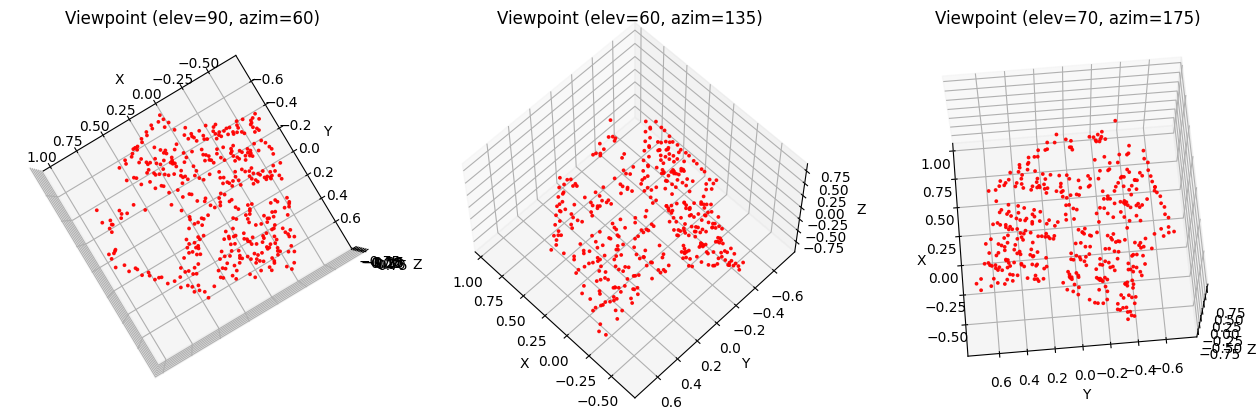

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_points(S, elevations, azimuths,roll, title_prefix):
    fig = plt.figure(figsize=(16, 5))

    for idx, (elev, azim, roll_angle) in enumerate(zip(elevations, azimuths,roll)):
        ax = fig.add_subplot(1, 3, idx + 1, projection='3d')
        ax.scatter(S[0, :], S[1, :], S[2, :], marker='o', s=3, c="red", alpha=0.9)
        ax.view_init(elev=elev, azim=azim, roll=roll_angle)
        ax.set_title(f"{title_prefix} (elev={elev}, azim={azim})")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

    plt.show()

# Change below angles for different view angles
elevations = [90, 60, 70]
azimuths = [60, 135, 175]
roll = [0, 0, 0]
plot_3D_points(S, elevations, azimuths,roll, 'Viewpoint')


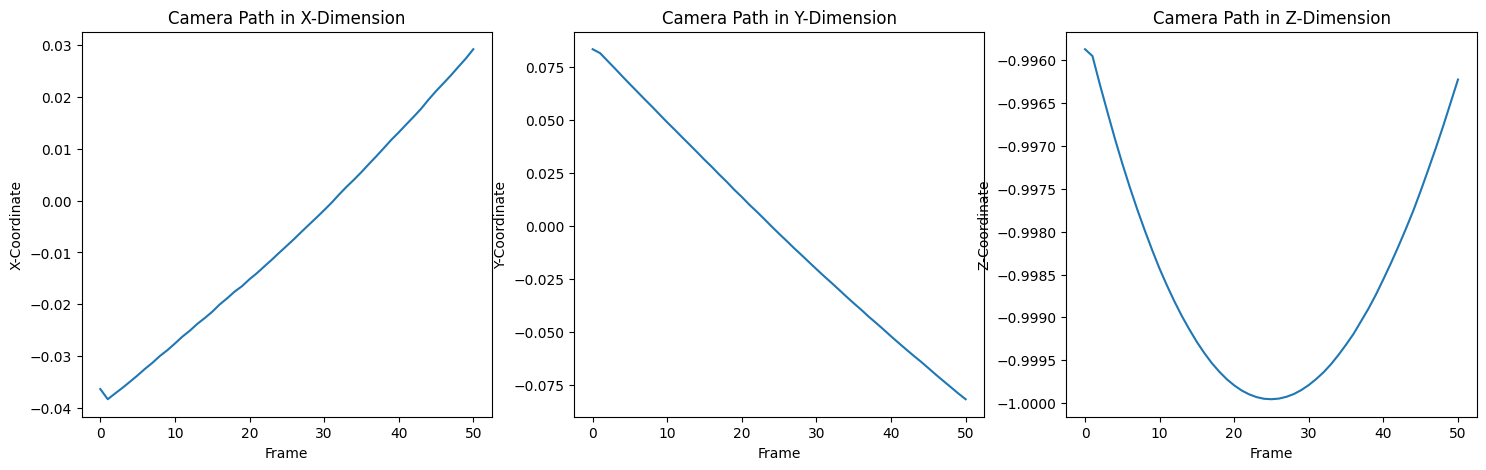

In [ ]:
def camera_positions(A):
    camera_pos = []
    for i in range(51):
        ai = A[i, :]
        aj = A[i + 51, :]
        ak = np.cross(ai, aj)
        ak_normalized = ak / np.linalg.norm(ak)
        camera_pos.append(ak_normalized)
        #camera_pos.append(ak)
    return np.array(camera_pos)

def plot_camera_path(camera_pos, dimension):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    dimensions = ['X', 'Y', 'Z']
    for idx, ax in enumerate(axes):
        ax.plot(camera_pos[:, idx], linestyle='-', markersize=6)
        ax.set_title(f'Camera Path in {dimensions[idx]}-Dimension')
        ax.set_xlabel('Frame')
        ax.set_ylabel(f'{dimensions[idx]}-Coordinate')

    plt.show()

# Plot predicted camera position
camera_pos = camera_positions(A)
plot_camera_path(camera_pos, ['X', 'Y', 'Z'])


# Note this is the difference in results between the first implementation and this implementation as shwon